In [18]:
import phylovelo as pv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

In [10]:
plt.rcParams['font.size'] = 12

In [2]:
tree_file = '/data3/wangkun/phylovelo_datasets/Linear/tree_origin_var0.02_rvg0.05.csv0.nwk'
phylo_tree, branch_colors = pv.ana_utils.loadtree(tree_file)
sampled_cells = [i.name for i in phylo_tree.get_terminals()]
cell_names, cell_states, cell_generation = pv.sim_utils.get_annotation('/data3/wangkun/phylovelo_datasets/Linear/tree_origin_var0.02_rvg0.05.csv0')
cell_states = pd.DataFrame(data=cell_states, index=cell_names).loc[sampled_cells]
cell_generation = pd.DataFrame(data=cell_generation, index=cell_names).loc[sampled_cells].to_numpy()

In [3]:
sd = pv.scData(phylo_tree=phylo_tree,
               cell_states=cell_states.to_numpy().T[0].astype('int'),
               cell_generation=cell_generation.T[0].astype('int'),
               cell_names=sampled_cells)

In [4]:
ge, base_expr = pv.sim_base_expr(sd.phylo_tree,
                                 cell_states,
                                 Ngene=2000,
                                 r_variant_gene=0.4,
                                 diff_map={0:[0],1:[0],2:[1],3:[2],4:[3]},
                                 forward_map={},
                                 mu0_loc=0,
                                 mu0_scale=1,
                                 drift_loc=0,
                                 drift_scale=0.3,
                                )

In [5]:
sd.count = pv.get_count_from_base_expr(pv.add_lineage_noise(sd.phylo_tree, base_expr), alpha=0.1)

In [6]:
sd.dimensionality_reduction()

/home/wangkun/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/wangkun/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


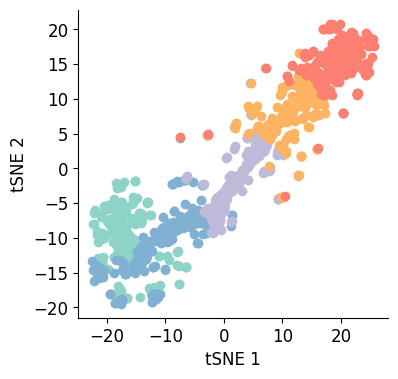

In [11]:
fig, ax = plt.subplots(figsize=(4, 4))
cmps = ['#8dd3c7','#80b1d3','#bebada','#fdb462','#fb8072']
for i in range(5):
    ax.scatter(sd.Xdr.iloc[sd.cell_states==i, 0], sd.Xdr.iloc[sd.cell_states==i, 1], c=cmps[i])
ax.set_xlabel('tSNE 1', )
ax.set_ylabel('tSNE 2', )
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [36]:
tree, branch_colors = pv.loadtree(tree_file)

In [37]:
mu = 0.1

mutations = dict()
global_mutid = -1
for i in tree.get_terminals():
    mut = []
    for j in tree.get_path(i):
        if j.name in mutations:
            mut = deepcopy(mutations[j.name])
        else:
            for _ in range(np.random.poisson(mu)):
                mut.append(global_mutid+1)
                global_mutid += 1
            mutations[j.name] = deepcopy(mut)

mut_table = []
cell_nemes = []
for i in tree.get_terminals():
    seq = np.zeros(global_mutid+1)
    seq[mutations[i.name]]=1
    mut_table.append(seq)
    cell_nemes.append(i.name)

In [213]:
tree.root.is_terminal()

False

In [147]:
init_cell_muts = initialize_mtmut()

1000it [00:01, 676.09it/s]                         


In [217]:
global_mutid = np.max([np.max(list(i)) for i in init_cell_muts if i])
mt_mutations = {'<0_0>':init_cell_muts}
for i in tqdm(Phylo.BaseTree._preorder_traverse(tree.root, lambda elem: elem.clades)):
    if not i.is_terminal():
        new_mts = cell_division_with_mt(init_cell_muts, np.max([np.max(list(i)) for i in init_cell_muts if i]), 1.6)
        for ind, j in enumerate(i.clades):
            mt_mutations[j.name] = new_mts[ind]


6366it [02:20, 45.32it/s]


In [220]:
tree.get_terminals()[0]

Clade(branch_length=1.0, name='<14_998>')

In [224]:
np.mean([len(i) for i in mt_mutations[tree.root.name]])

2.541

In [225]:
np.mean([len(i) for i in mt_mutations[tree.get_terminals()[0].name]])

2.746161719549642

In [70]:
from tqdm import tqdm
from scipy.special import comb
from Bio import Phylo

In [146]:
def initialize_mtmut(nmts=1000, mut_rate=0.2, len_mtdna=16569, birth_rate=1, death_rate=0.1):
    sys = Gillespie(1, [1], nmts-1, mut_rate)
    sys.add_reaction(lambda t: birth_rate, [1], [2], 0)
    sys.add_reaction(lambda t: death_rate, [1], [0], 0)
    sys.evolute(10000)
    return [i.mt_muts for i in sys.curr_cells]

In [182]:
def cell_division_with_mt(mt_muts, global_mutid, mut_rate):
    new_mts = []
    for mt in mt_muts:
        new_mts.append(deepcopy(mt))
        for new_mut in range(np.random.poisson(mut_rate)):
            new_mts[-1].add(global_mutid+1)
            global_mutid += 1
        new_mts.append(deepcopy(mt))
        for new_mut in range(np.random.poisson(mut_rate)):
            new_mts[-1].add(global_mutid+1)
            global_mutid += 1 
    division = np.random.binomial(1,0.5,2000).astype(bool)
    cell1 = np.array(new_mts)[division]
    cell2 = np.array(new_mts)[~division]
    return list(cell1), list(cell2)

In [184]:
class Cell:
    def __init__(
        self,
        Ngene:int = None,
        state:int = 0,
        gen:int = None,
        cid:int = None,
        parent:int = None,
        tb:float = None,
        td:float = None,
        mt_muts:set = set(),
    ):
        self.state = state
        self.parent = parent
        self.cid = cid
        self.gen = gen
        self.tb = tb
        self.td = td
        self.mt_muts = mt_muts
        
class Reaction:
    '''
    Cell division/differentiation type
    
    Args:
        rate:
            reaction rate function
        num_lefts:
            Cell numbers before reaction
        num_right:
            Cell numbers after reaction
        index:
            Reaction index
    '''
    def __init__(self, rate:callable=None, num_lefts:list=None, num_rights:list=None, index:int=None):
        self.rate = rate
        assert len(num_lefts) == len(num_rights)
        self.num_lefts = np.array(num_lefts)
        self.num_rights = np.array(num_rights)
        self.num_diff = self.num_rights - self.num_lefts
        self.index = index
        if 2 * sum(num_lefts) == sum(num_rights):
            self.type = "proliferate"
        else:
            self.type = "death"

    def combine(self, n, s):
        return np.prod(comb(n, s))

    def propensity(self, n, t):
        return self.rate(t) * self.combine(n, self.num_lefts)
    
class Gillespie:
    '''
    Gillespie simulation
    
    Args:
        num_elements: 
            Cell type number
        inits: 
            Initial cell number
        max_cell_num: 
            Maximum cell number
    '''
    def __init__(
        self,
        num_elements:int,
        inits:list=None,
        init_cells:list=None,
        max_cell_num:int=10000,
        mt_mut_rate:int = 1,
    ):

        assert num_elements > 0
        self.num_elements = num_elements
        self.reactions = []
        if inits is None:
            self.n = [np.ones(self.num_elements)]
        else:
            self.n = [np.array(inits)]
        self.anc_cells = []
        if init_cells:
            self.curr_cells = init_cells
        else:
            self.curr_cells = [Cell(gen=0, parent=-1, cid=0, tb=0)]

        self.generation_time = [0]
        self.max_cell_num = max_cell_num
        self.mt_mut_rate = mt_mut_rate

    def add_reaction(self, rate:callable=None, num_lefts:list=None, num_rights:list=None, index:int=None):
        '''
        Add reactions to simulation
        
        Args:
            rate:
                reaction rate function
            num_lefts:
                Cell numbers before reaction
            num_right:
                Cell numbers after reaction
            index:
                Reaction index
        '''
        assert len(num_lefts) == self.num_elements
        assert len(num_rights) == self.num_elements
        self.reactions.append(Reaction(rate, num_lefts, num_rights, index))

    def evolute(self, steps:int):
        '''
        Run simulation
        
        Args:
            steps:
                How many steps to evolute before step
        '''
        self.t = [0]
        self.log = []
        cell_num_per_gen = {0: self.n[0][0]}
        cell_id_per_gen = {0: self.n[0][0]}
        self.global_mut_id = -1
        
        def proliferate():
            node = np.random.choice(self.curr_cells)
            l1, l2 = deepcopy(node), deepcopy(node)
            l1.parent, l2.parent = node.cid, node.cid
            l1.gen += 1
            l2.gen += 1
            l1.tb, l2.tb = self.t[-1], self.t[-1]
            try:
                index = cell_id_per_gen[l1.gen] + 1
            except:
                index = 0
                cell_id_per_gen.update({l1.gen: 0})
                cell_num_per_gen.update({l1.gen: 0})

            l1.cid, l2.cid = index, index + 1
            for new_mut in range(np.random.poisson(self.mt_mut_rate)):
                self.global_mut_id += 1 
                l1.mt_muts.add(self.global_mut_id)
            for new_mut in range(np.random.poisson(self.mt_mut_rate)):
                self.global_mut_id += 1 
                l2.mt_muts.add(self.global_mut_id)
                    
            self.curr_cells.append(l1)
            self.curr_cells.append(l2)

            cell_num_per_gen[l1.gen] += 2
            cell_id_per_gen[l1.gen] += 2
            cell_num_per_gen[l1.gen - 1] -= 1

            self.curr_cells.remove(node)
            node.td = self.t[-1]
            self.anc_cells.append(node)
        
        def death():
            node = np.random.choice(self.curr_cells)
            cell_num_per_gen[node.gen] -= 1
            self.curr_cells.remove(node)
            self.anc_cells.append(node)

 

        class SwitchCase(object):
            def case_to_func(self, reaction):
                self.reaction = reaction
                method = getattr(self, reaction.type + "1")
                return method

            def proliferate1(self):
                proliferate()

            def death1(self):
                death()

        cls = SwitchCase()

        with tqdm(total=self.max_cell_num) as pbar:
            
            for _ in range(steps):
                
                all_cell_num = sum(cell_num_per_gen.values())
                pbar.update(all_cell_num - pbar.n)
                if all_cell_num > self.max_cell_num:
                    # print("\n maximum cell number reached")
                    break

                avg_generation = np.dot(
                    list(cell_num_per_gen.keys()), list(cell_num_per_gen.values())
                ) / sum(cell_num_per_gen.values())

                self.generation_time.append(avg_generation)
                A = np.array(
                    [
                        rec.propensity(self.n[-1], avg_generation)
                        for rec in self.reactions
                    ]
                )

                A0 = A.sum()
                A /= A0
                t0 = -np.log(np.random.random()) / A0
                self.t.append(self.t[-1] + t0)
                react = np.random.choice(self.reactions, p=A)

                self.log.append(react.index)
                self.n.append(self.n[-1] + react.num_diff)

                cls.case_to_func(react)()
            